# Binary Classification using Naive Bayes Algorithm
In notebook, we will attempt to build a naive classifier for weather data into rain/no rain days. Our two classes will be (isRain=1), which means that rain occurred on the given day, and (isRain=0), which is the opposite. We will be fetching raw historical weather data for a period of 6 months, and build our dataset by choosing some features from the raw data.

## Data Preparation
First, we will create our dataset by fetching the weather data from weatherapi, a weather and geolocation api found at https://www.weatherapi.com/. **Note that we only have a free 14-day trial, which expires on Oct 8th 2022.** The limit for this api is 5 million calls/month.

We will be fetching 6 months of data for the City of New York, between March and August (since this contains periods of rainfall as well as summer days).

In [ ]:
import requests
import json
import pandas as pd

#Connecting to weather data api
#API Key for authentication
#This is valid only till Oct 8th since it is a free trial
api_key = '29ad24f5507346758f9222528222409'
#API Endpoint for historical weather data
api_url = 'http://api.weatherapi.com/v1/history.json'
api_url += '?key=' + api_key
loc_name = 'NY'

#Creating a helper function to perform api call for each month
def monthlyWeatherCallout(start,end):
  #Adding req parameters
  http_url = api_url + '&q='+ loc_name + '&dt=' + start + '&end_dt=' + end
  print('URL: '+http_url)
  response = requests.get(http_url)
  weather_data_response = json.loads(response.text)
  print('Response Status: '+str(response.status_code))
  return weather_data_response

#Performing http call for each month, since the api returns only 30 days at max in the free trial
march_monthly_data = monthlyWeatherCallout('2022-03-01','2022-03-31')
april_monthly_data = monthlyWeatherCallout('2022-04-01','2022-04-30')
may_monthly_data = monthlyWeatherCallout('2022-05-01','2022-05-31')
june_monthly_data = monthlyWeatherCallout('2022-06-01','2022-06-30')
july_monthly_data = monthlyWeatherCallout('2022-07-01','2022-07-31')
aug_monthly_data = monthlyWeatherCallout('2022-08-01','2022-08-31')

#Combining monthly raw data into single list
weather_data = march_monthly_data["forecast"]["forecastday"] + april_monthly_data["forecast"]["forecastday"] + may_monthly_data["forecast"]["forecastday"] + june_monthly_data["forecast"]["forecastday"] + july_monthly_data["forecast"]["forecastday"] + aug_monthly_data["forecast"]["forecastday"]
#Erase variables to save memory
%reset_selective 'monthly_data'

URL: http://api.weatherapi.com/v1/history.json?key=29ad24f5507346758f9222528222409&q=NY&dt=2022-03-01&end_dt=2022-03-31
Response Status: 200
URL: http://api.weatherapi.com/v1/history.json?key=29ad24f5507346758f9222528222409&q=NY&dt=2022-04-01&end_dt=2022-04-30
Response Status: 200
URL: http://api.weatherapi.com/v1/history.json?key=29ad24f5507346758f9222528222409&q=NY&dt=2022-05-01&end_dt=2022-05-31
Response Status: 200
URL: http://api.weatherapi.com/v1/history.json?key=29ad24f5507346758f9222528222409&q=NY&dt=2022-06-01&end_dt=2022-06-30
Response Status: 200
URL: http://api.weatherapi.com/v1/history.json?key=29ad24f5507346758f9222528222409&q=NY&dt=2022-07-01&end_dt=2022-07-31
Response Status: 200
URL: http://api.weatherapi.com/v1/history.json?key=29ad24f5507346758f9222528222409&q=NY&dt=2022-08-01&end_dt=2022-08-31
Response Status: 200
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Here is what the raw weather data looks like for the first 5 days:

In [ ]:
#Printing raw data for first day
for weather_element in weather_data[:1]:
  print(str(weather_element)[:1000]+'...')



{'date': '2022-03-01', 'date_epoch': 1646092800, 'day': {'maxtemp_c': 6.7, 'maxtemp_f': 44.1, 'mintemp_c': -1.9, 'mintemp_f': 28.6, 'avgtemp_c': 2.9, 'avgtemp_f': 37.1, 'maxwind_mph': 10.7, 'maxwind_kph': 17.3, 'totalprecip_mm': 0.0, 'totalprecip_in': 0.0, 'avgvis_km': 10.0, 'avgvis_miles': 6.0, 'avghumidity': 46.0, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/day/122.png', 'code': 1009}, 'uv': 0.0}, 'astro': {'sunrise': '07:30 AM', 'sunset': '06:47 PM', 'moonrise': '07:19 AM', 'moonset': '05:37 PM', 'moon_phase': 'Waning Crescent', 'moon_illumination': '11'}, 'hour': [{'time_epoch': 1646110800, 'time': '2022-03-01 00:00', 'temp_c': -1.9, 'temp_f': 28.6, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 4.0, 'wind_kph': 6.5, 'wind_degree': 2, 'wind_dir': 'N', 'pressure_mb': 1028.0, 'pressure_in': 30.34, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 34, 'cloud': 22, 'feels

Each json row contains a 'day' element which has daily statistics, and an 'hour' array which has hourly measurements for each of the 24 hours in a day.

### Creating the dataset

For our classification task, the features we will select are:
*   Humidity
*   Max Wind Speeed
*   Daily avg. Cloud coverage (as a percentage)

And for simplicity, we will assume a rainy day (isRain=1) when the precipitation for the given day is more than 0.

Note that in the raw data, cloud coverage (cc) is only present in the 'hour' array for each hour of a day, so we calculate the daily by finding the average over the 24 hours for a given day.

In [ ]:
#Creating lists to store weather data
weather_dates,weather_winds,weather_cc,weather_humidity,weather_rain = [],[],[],[],[]

for weather_element in weather_data:
  weather_dates.append(weather_element["date"])
  weather_winds.append(weather_element["day"]["maxwind_mph"])
  weather_humidity.append(weather_element["day"]["avghumidity"])
  #Iterating through each hour to get avg cloud coverage (cc)
  avgCC = 0
  for hourly in weather_element["hour"]:
    avgCC += float(hourly["cloud"])

  avgCC = avgCC/24
  weather_cc.append(avgCC)
  #Setting the class variable isRain if precipitation was more than 0
  isRain = 1 if float(weather_element["day"]["totalprecip_in"]) > 0 else 0
  weather_rain.append(isRain)

#Creating pandas dataframe to build dataset
df = pd.DataFrame(list(zip(weather_dates,weather_winds,weather_cc,weather_humidity,weather_rain)), columns = ['Date','Max Wind Speed','Avg Cloud Coverage','Humidity','isRain'])
display(df)

#Saving dataset to google drive
from google.colab import drive

drive.mount('drive')
df.to_csv('weather.csv')
!cp weather.csv "drive/My Drive/Colab Notebooks/Data/weather.csv"

,Date,Max Wind Speed,Avg Cloud Coverage,Humidity,isRain
0,2022-03-01,10.7,51.958333,46.0,0
1,2022-03-02,12.3,32.875000,62.0,0
2,2022-03-03,19.0,33.208333,53.0,0
3,2022-03-04,12.8,20.208333,32.0,0
4,2022-03-05,8.9,52.833333,49.0,0
...,...,...,...,...,...
179,2022-08-27,9.2,53.916667,57.0,1
180,2022-08-28,11.6,36.083333,63.0,0
181,2022-08-29,11.4,24.125000,66.0,0
182,2022-08-30,9.4,41.916667,68.0,1


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


### Visualizing the Data
Now that we have our dataset ready as a pandas dataframe, we can explore what the data looks like. We can first plot the features in 3d:

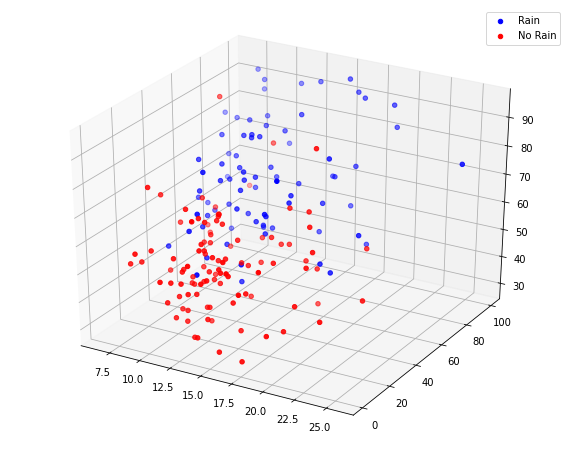

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')

df_class1 = df[df['isRain']==1]
df_class2 = df.drop(df_class1.index)
ax.scatter(df_class1['Max Wind Speed'],df_class1['Avg Cloud Coverage'],df_class1['Humidity'],color='blue',label='Rain')
ax.scatter(df_class2['Max Wind Speed'],df_class2['Avg Cloud Coverage'],df_class2['Humidity'],color='red',label='No Rain')

plt.legend(loc="upper right")
plt.show()

We can also view the data in 2d by performing dimensionality reduction using PCA. This makes it easier for us to draw an approximate decision boundary:

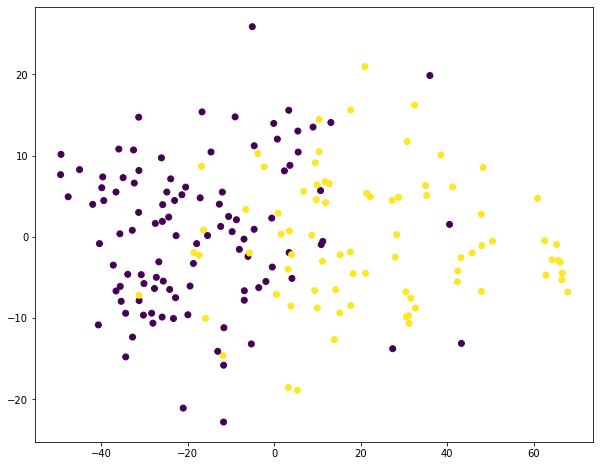

In [ ]:
#PCA 
from sklearn.decomposition import PCA
X = df[['Max Wind Speed', 'Avg Cloud Coverage', 'Humidity']]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = plt.figure(figsize=[10,8])
fig = plt.scatter(components[:,0], components[:,1], c=df['isRain'])
plt.show()


We can hand-draw a decision boundary on the 2d plot (which will translate to a 3d surface in the 3d plot, but we will limit ourselves to the 2d plot for simplicity).


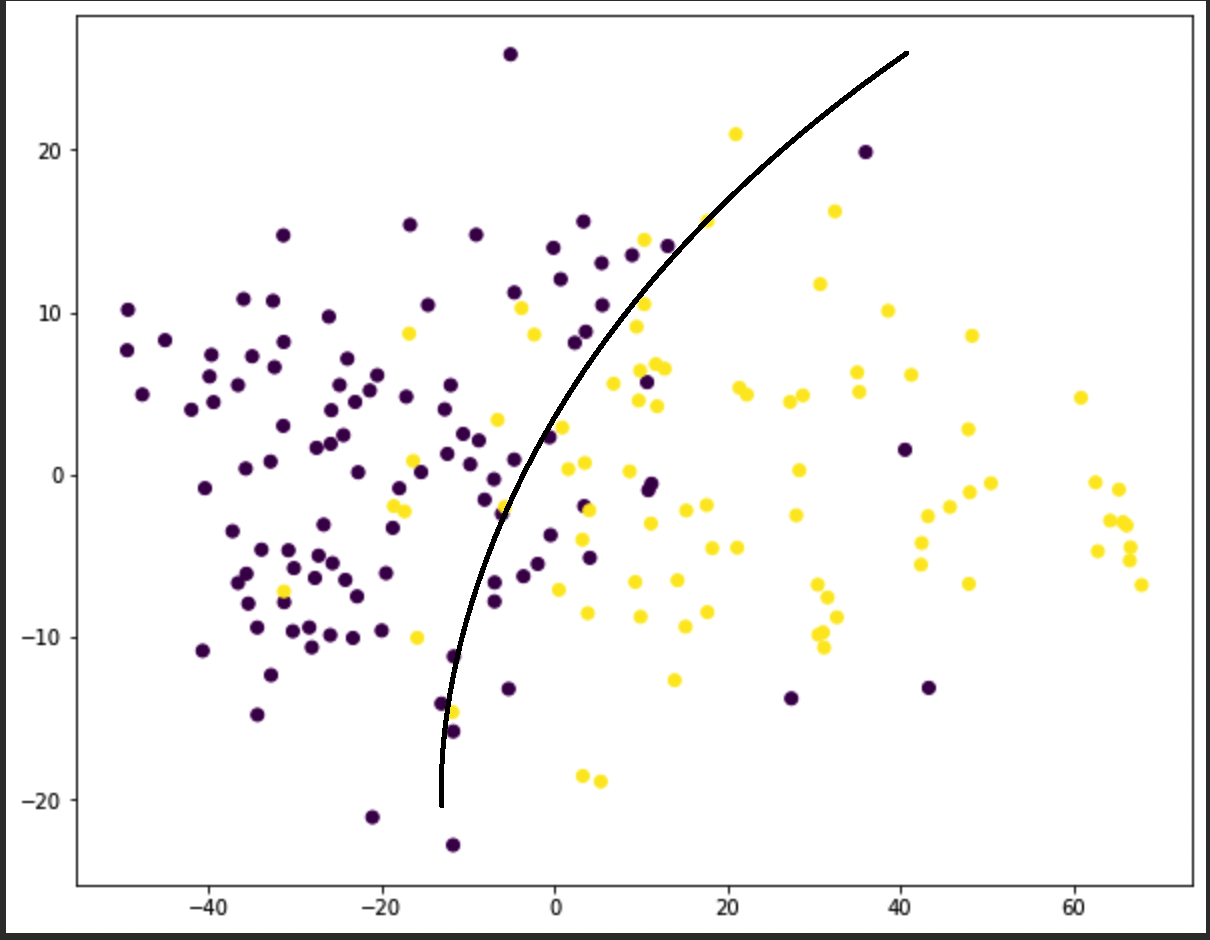

## Building the Classifier
Now, we will attempt to build the naive classifier. First, we will shuffle and split the data into training & test sets (80-20 split).

In [ ]:
#Split into train/test dataframes (80-20)
train_set = df.sample(frac=0.8, random_state=234)
test_set = df.drop(train_set.index)

### Visualizing the train/test data
Here are some plots of the train/test data:

Training Data -

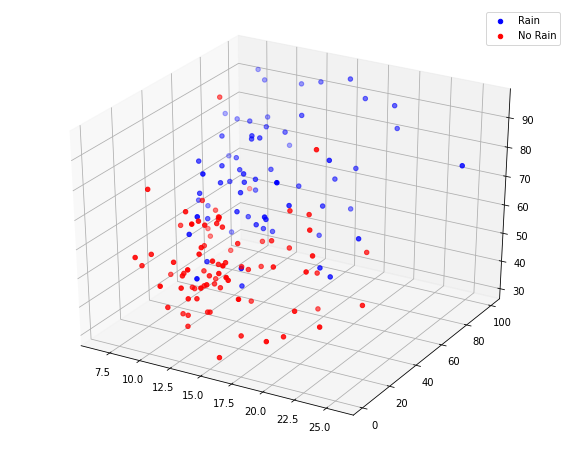


 Training Data in 2d using PCA: 



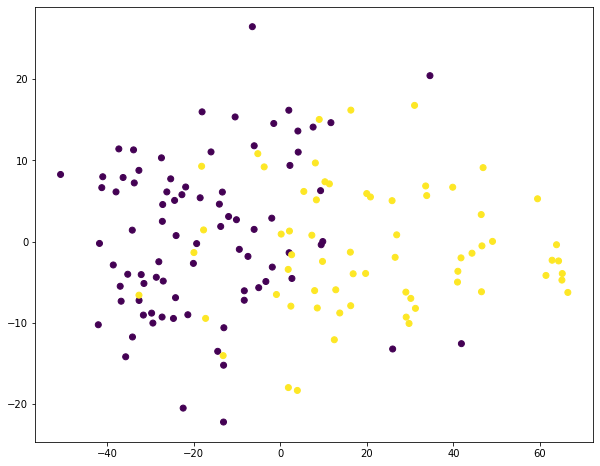

In [ ]:
#Training data:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')

df_class1 = train_set[train_set['isRain']==1]
df_class2 = train_set.drop(df_class1.index)
ax.scatter(df_class1['Max Wind Speed'],df_class1['Avg Cloud Coverage'],df_class1['Humidity'],color='blue',label='Rain')
ax.scatter(df_class2['Max Wind Speed'],df_class2['Avg Cloud Coverage'],df_class2['Humidity'],color='red',label='No Rain')

plt.legend(loc="upper right")
plt.show()

print('\n Training Data in 2d using PCA: \n')
X = train_set[['Max Wind Speed', 'Avg Cloud Coverage', 'Humidity']]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = plt.figure(figsize=[10,8])
fig = plt.scatter(components[:,0], components[:,1], c=train_set['isRain'])
plt.show()


Test Data -

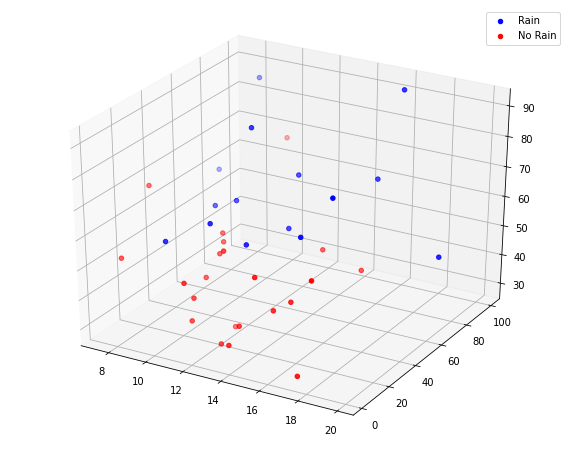


 Test Data in 2d using PCA: 



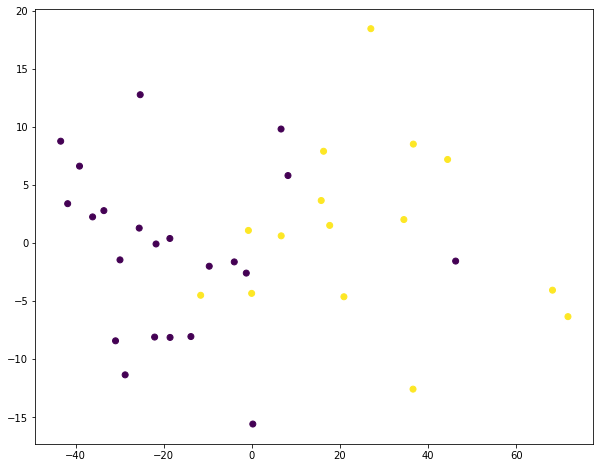

In [ ]:
#Test data:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')

df_class1 = test_set[test_set['isRain']==1]
df_class2 = test_set.drop(df_class1.index)
ax.scatter(df_class1['Max Wind Speed'],df_class1['Avg Cloud Coverage'],df_class1['Humidity'],color='blue',label='Rain')
ax.scatter(df_class2['Max Wind Speed'],df_class2['Avg Cloud Coverage'],df_class2['Humidity'],color='red',label='No Rain')

plt.legend(loc="upper right")
plt.show()

print('\n Test Data in 2d using PCA: \n')
X = test_set[['Max Wind Speed', 'Avg Cloud Coverage', 'Humidity']]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = plt.figure(figsize=[10,8])
fig = plt.scatter(components[:,0], components[:,1], c=test_set['isRain'])
plt.show()

### Naive Bayes Algorithm
We will use the naive bayes theorem to compute the probabilities for each class: (**Class conditional probabilities)**

*  P(Rain | X) = [P(X | Rain)*P(Rain)] / P(X)

And similiar for P(No Rain | X):

*  P(No Rain | X) = [P(X | No Rain)*P(No Rain)] / P(X)


P(Rain) is the prior probability. For simplicity, we will assume that there is a 50% chance of rain on a given day, so the priors will be 0.5.


In [ ]:
#Computing priors
priors = [0.5, 0.5]

Next, we will estimate the likelihood probability P(X | Rain) and P(X | No Rain) by assuming the data fits a gaussian (normal) distribution:

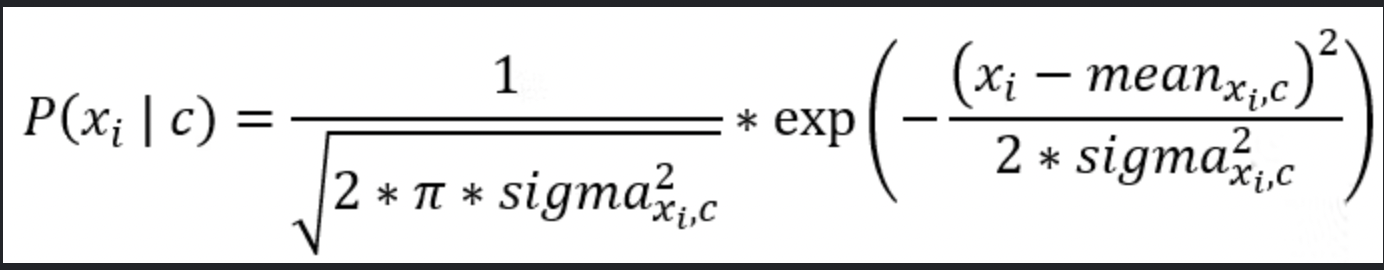

Here, we will need to calculate the mean and variance for each feature for each class (mean_xi,c, sigma^2_xi,c)

In [ ]:
import numpy as np

FEATURE_NAMES = ['Max Wind Speed', 'Avg Cloud Coverage', 'Humidity']
#Calculating mean, variance for each feature for each class
means = {}
vars = {}

for i in range(2):
  filtered_set = train_set[train_set['isRain']==i]  
  x = filtered_set[FEATURE_NAMES].to_numpy()
  m = {}
  v = {}
  for idx, val in enumerate(np.mean(x, axis=0)):
    m.update({FEATURE_NAMES[idx]:val})
  for idx, val in enumerate(np.var(x, axis=0)):
    v.update({FEATURE_NAMES[idx]:val})
  means.update({i:m})
  vars.update({i:v})  

print(means)
print(vars)


{0: {'Max Wind Speed': 13.19146341463415, 'Avg Cloud Coverage': 27.73170731707317, 'Humidity': 52.03658536585366}, 1: {'Max Wind Speed': 12.804615384615385, 'Avg Cloud Coverage': 62.208333333333336, 'Humidity': 70.47692307692307}}
{0: {'Max Wind Speed': 11.185414931588342, 'Avg Cloud Coverage': 298.48759728832044, 'Humidity': 113.08402736466391}, 1: {'Max Wind Speed': 13.930901775147928, 'Avg Cloud Coverage': 479.98744658119665, 'Humidity': 149.1725443786982}}


Now, we will define a helper function which will compute the gaussian distribution (likelihood):


In [ ]:
#Creating the helper function to predict the class conditional probabilities
def likelihood_gaussian(x, mean, variance):
  exponent = np.exp(-(np.power(x - mean, 2)/(2 * variance)))
  return (1/(np.sqrt(2 * np.pi * variance)))*exponent

Finally, we will create a helper function to perform the predictions on the test set:

In [ ]:
def predict(data):
  predictions = []
  for idx,row in data.iterrows():
    class_conditionals = []
    for i in range(2):
      class_conditional = 0
      for feature in FEATURE_NAMES:
        #Get the mean,var for the feature
        m = means.get(i).get(feature)
        v = vars.get(i).get(feature)
        #Calculate the likelihood of the feature
        likelihood = likelihood_gaussian(float(row[feature]),m,v)
        #Calculate class conditional as the product of per feature probability
        class_conditional = likelihood*priors[i] if class_conditional==0 else class_conditional*(likelihood*priors[i])
      class_conditionals.append(class_conditional)
      #Predict the class based on the higher probability
    predictions.append(0 if class_conditionals[0] > class_conditionals[1] else 1)
  return predictions

test_set['Prediction'] = predict(test_set)
display(test_set)

,Date,Max Wind Speed,Avg Cloud Coverage,Humidity,isRain,Prediction
3,2022-03-04,12.8,20.208333,32.0,0,0
15,2022-03-16,7.4,31.750000,68.0,0,1
19,2022-03-20,15.9,80.958333,67.0,1,1
20,2022-03-21,15.9,17.750000,46.0,0,0
23,2022-03-24,15.9,100.000000,91.0,1,1
26,2022-03-27,17.4,47.625000,49.0,0,0
32,2022-04-02,15.2,14.916667,43.0,0,0
34,2022-04-04,15.4,47.500000,53.0,0,0
45,2022-04-15,13.2,5.041667,32.0,0,0
54,2022-04-24,11.0,35.666667,56.0,0,0


##Results

Now that we have our predictions, we will evaluate our fit. First we will plot our predictions:

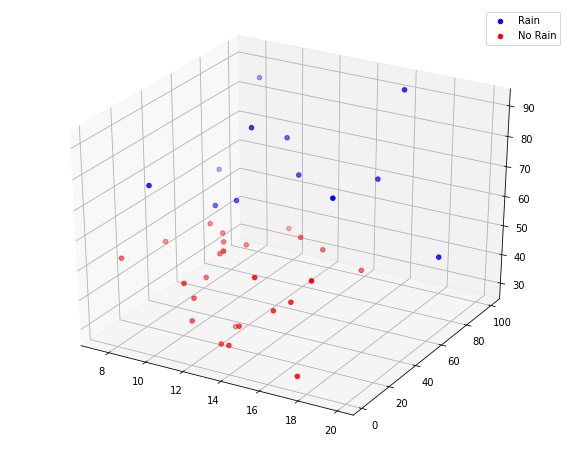

In [ ]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')

df_class1 = test_set[test_set['Prediction']==1]
df_class2 = test_set.drop(df_class1.index)
ax.scatter(df_class1['Max Wind Speed'],df_class1['Avg Cloud Coverage'],df_class1['Humidity'],color='blue',label='Rain')
ax.scatter(df_class2['Max Wind Speed'],df_class2['Avg Cloud Coverage'],df_class2['Humidity'],color='red',label='No Rain')

plt.legend(loc="upper right")
plt.show()

And in 2-dimensions using PCA:


 Test Data Predictions in 2d using PCA: 



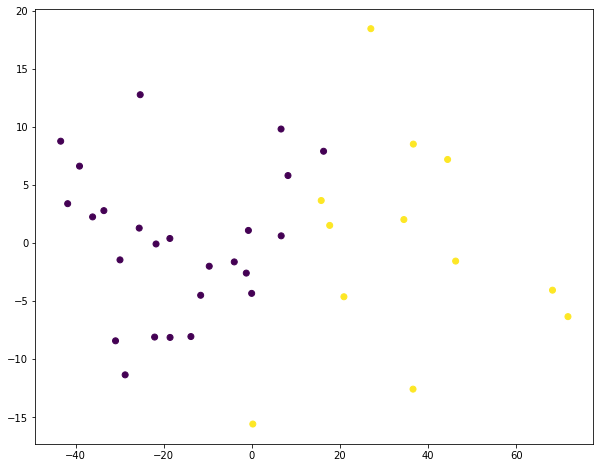

In [ ]:
print('\n Test Data Predictions in 2d using PCA: \n')
X = test_set[['Max Wind Speed', 'Avg Cloud Coverage', 'Humidity']]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = plt.figure(figsize=[10,8])
fig = plt.scatter(components[:,0], components[:,1], c=test_set['Prediction'])
plt.show()

We can also calculate the accuracy:

In [ ]:
correct = 0
for idx,row in test_set.iterrows():
  if row['isRain'] == row['Prediction']:
    correct += 1
accuracy = (correct/test_set.shape[0])*100
print('Accuracy: '+str(accuracy))

Accuracy: 81.08108108108108


Therefore, we have achieved a moderately high accuracy of 81% on the test set using naive bayes classification, but note that there are only 37 samples in the test set.

We can also visualize the decision boundary by generating sample data and predicting for each point:

3d Plot: 



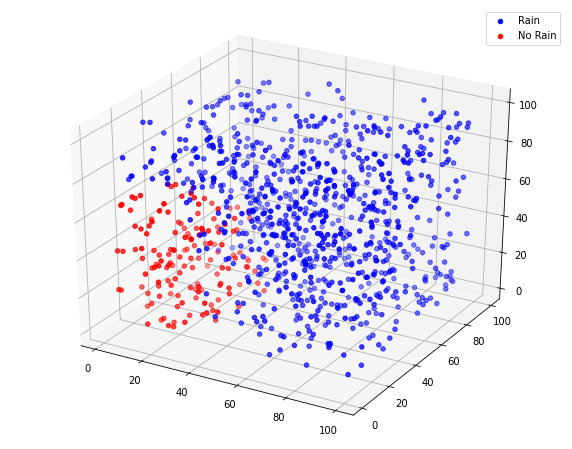

2d PCA Plot: 



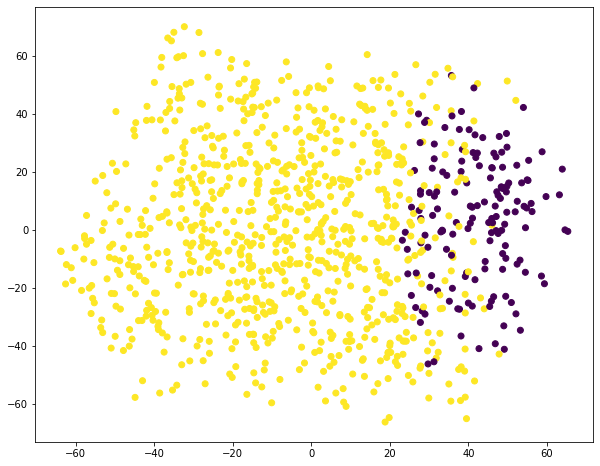

In [ ]:
#Visualizing decision boundary of classifier
#Creating some sample data using np.random.uniform()
sample_data = {}
np.random.seed(234)
for feature in FEATURE_NAMES:
  sample_data.update({feature:np.random.uniform(1,100,(1000,))})

sample_data_df = pd.DataFrame(sample_data)
#Predicting on the sample data
sample_data_df['Prediction'] = predict(sample_data_df)
#Plotting the result in 3d:
print('3d Plot: \n')
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')

df_class1 = sample_data_df[sample_data_df['Prediction']==1]
df_class2 = sample_data_df.drop(df_class1.index)
ax.scatter(df_class1['Max Wind Speed'],df_class1['Avg Cloud Coverage'],df_class1['Humidity'],color='blue',label='Rain')
ax.scatter(df_class2['Max Wind Speed'],df_class2['Avg Cloud Coverage'],df_class2['Humidity'],color='red',label='No Rain')

plt.legend(loc="upper right")
plt.show()

#Plotting the result in 2d using PCA:
print('2d PCA Plot: \n')
X = sample_data_df[['Max Wind Speed', 'Avg Cloud Coverage', 'Humidity']]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = plt.figure(figsize=[10,8])
fig = plt.scatter(components[:,0], components[:,1], c=sample_data_df['Prediction'])
plt.show()


Obviously, the boundary seems to be very different from the original hand-drawn boundary, which seems to split the data more evenly between the two classes:

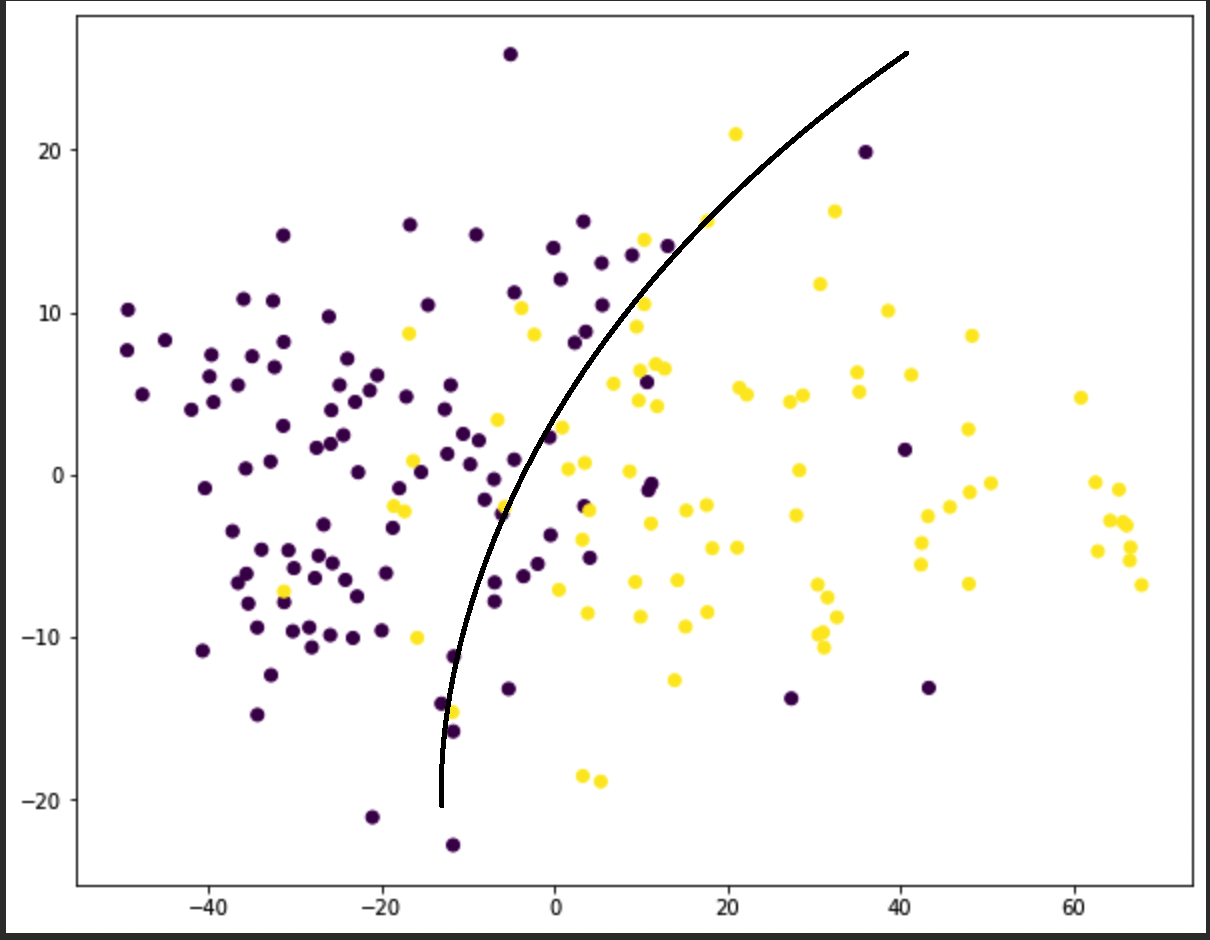